In [62]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras import callbacks 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import fasttext


In [24]:
h_train = pd.read_json("../input/nlp-s6-proj-data/Headline_Trainingdata.json")
h_val = pd.read_json("../input/nlp-s6-proj-data/Headline_Trialdata.json")
h_test = pd.read_json("../input/nlp-s6-proj-data/Headlines_Testdata.json")

## Headline

In [25]:
h_train.head()

,id,company,title,sentiment
0,2,Morrisons,Morrisons book second consecutive quarter of s...,0.430
1,3,IMI,IMI posts drop in first-quarter organic revenu...,-0.344
2,4,Glencore,Glencore to refinance its short-term debt earl...,0.340
3,5,Ryanair,EasyJet attracts more passengers in June but s...,0.259
4,6,Barclays,Barclays 'bad bank' chief to step down,-0.231


In [26]:
h_train.values[0]

array([2, 'Morrisons',
       'Morrisons book second consecutive quarter of sales growth', 0.43],
      dtype=object)

In [27]:
pos_neg_neu_train = {-1:[], 0:[], 1:[]}

for i in h_train.values:
    if(i[3]>-1 and i[3]<=-0.25):
        pos_neg_neu_train[-1].append([i[3], i[2]])
    if(i[3]>-0.25 and i[3]<=0.25):
        pos_neg_neu_train[0].append([i[3], i[2]])
    if(i[3]>0.25 and i[3]<=1):
        pos_neg_neu_train[1].append([i[3], i[2]])

In [28]:
print('Negative headlines => ', str(len(pos_neg_neu_train[-1])),'\nNeutral headlines => ', str(len(pos_neg_neu_train[0])),'\nPositive headlines => ', str(len(pos_neg_neu_train[1])))

Negative headlines =>  317 
Neutral headlines =>  428 
Positive headlines =>  397


In [29]:
pos_neg_neu_val = {-1:[], 0:[], 1:[]}

for i in h_val.values:
    if(i[3]>-1 and i[3]<=-0.25):
        pos_neg_neu_val[-1].append([i[1], i[3]])
    if(i[3]>-0.25 and i[3]<=0.25):
        pos_neg_neu_val[0].append([i[1], i[3]])
    if(i[3]>0.25 and i[3]<=1):
        pos_neg_neu_val[1].append([i[1], i[3]])

In [30]:
pos_neg_neu_val

{-1: [['Tesco says UK store closures put 2000 jobs at risk', -0.9],
  ['Reed Elsevier share price slides on underwhelming full-year results',
   -0.9],
  ['Kingfisher bid for Mr Bricolage runs into trouble', -0.30000000000000004],
  ['Kingfisher bid for Mr Bricolage runs into trouble', -0.30000000000000004]],
 0: [['Diageo stays neutral on India boardroom turmoil', -0.2],
  ['BP ends 27-year sponsorship of Tate as falling oil price takes toll',
   -0.2]],
 1: [["CRH's concrete bid for Holcim Lafarge assets", 0.30000000000000004],
  ["CRH's concrete bid for Holcim Lafarge assets", 0.30000000000000004],
  ["Glencore's annual results beat forecasts", 0.9],
  ['Markets Shire up 2.5% and Baxalta up 6% on $32bn deal', 0.8],
  ['Markets Shire up 2.5% and Baxalta up 6% on $32bn deal', 0.8]]}

In [31]:
print('Negative headlines => ', str(len(pos_neg_neu_val[-1])),'\nNeutral headlines => ', str(len(pos_neg_neu_val[0])),'\nPositive headlines => ', str(len(pos_neg_neu_val[1])))

Negative headlines =>  4 
Neutral headlines =>  2 
Positive headlines =>  5


In [32]:
X_vals_tr = []
for i in pos_neg_neu_train:
    for j in pos_neg_neu_train[i]:
        X_vals_tr.append([j[1]])
        if(i == -1):
            X_vals_tr[-1].extend(['Negative'])
        elif(i == 0):
            X_vals_tr[-1].extend(['Neutral'])
        else:
            X_vals_tr[-1].extend(['Positive'])
X_vals_tr = np.array(X_vals_tr)

In [33]:
X_vals_tr[0]

array(['IMI posts drop in first-quarter organic revenue; warns on full year',
       'Negative'], dtype='<U116')

In [34]:
headLine_train = pd.DataFrame({'Title':X_vals_tr[:,0],'Sentiment':X_vals_tr[:,1]})

In [35]:
X_vals_vl = []
for i in pos_neg_neu_val:
    for j in pos_neg_neu_val[i]:
        X_vals_vl.append([j[0]])
        if(i == -1):
            X_vals_vl[-1].extend(['Negative'])
        elif(i == 0):
            X_vals_vl[-1].extend(['Neutral'])
        else:
            X_vals_vl[-1].extend(['Positive'])
X_vals_vl = np.array(X_vals_vl)

In [36]:
X_vals_vl[0]

array(['Tesco says UK store closures put 2000 jobs at risk', 'Negative'],
      dtype='<U67')

In [37]:
headLine_val = pd.DataFrame({'Title':X_vals_vl[:,0],'Sentiment':X_vals_vl[:,1]})

In [38]:
headLine_val.head()

,Title,Sentiment
0,Tesco says UK store closures put 2000 jobs at ...,Negative
1,Reed Elsevier share price slides on underwhelm...,Negative
2,Kingfisher bid for Mr Bricolage runs into trouble,Negative
3,Kingfisher bid for Mr Bricolage runs into trouble,Negative
4,Diageo stays neutral on India boardroom turmoil,Neutral


In [39]:
headLine_train.head()

,Title,Sentiment
0,IMI posts drop in first-quarter organic revenu...,Negative
1,Barclays share price subdued as bank faces fre...,Negative
2,Diageo sales disappoint as currency and compar...,Negative
3,Smith & Nephew recalls hip-replacement components,Negative
4,Tesco is torn apart as watchdog finds supermar...,Negative


## Preprocessing

In [42]:
import nltk
from nltk.corpus import stopwords

In [43]:
def tokenize_data(dataset):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    for i in range(dataset.shape[0]):
        dataset["Title"][i] = tokenizer.tokenize(dataset["Title"][i])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])
    return dataset

In [44]:
def remove_stop_words(dataset):
    stop_words = set(stopwords.words('english'))
    for i in range(dataset.shape[0]):
        dataset["Title"][i] = ([token.lower() for token in dataset["Title"][i] if token not in stop_words])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])
    return dataset

In [45]:
def normalize(dataset):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for i in range(dataset.shape[0]):
        dataset.Title[i] = " ".join([lemmatizer.lemmatize(token) for token in dataset.Title[i]]).strip()
#         dataset["Title"][i] = " ".join(dataset["Title"][i])

    return dataset

In [46]:
def remove_garbage(dataset):
    garbage = "~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    for i in range(dataset.shape[0]):
        dataset.Title[i] = " ".join([char for char in dataset.Title[i] if char not in garbage])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])

    return dataset

In [47]:
headLine_train['Title'][0]

'IMI posts drop in first-quarter organic revenue; warns on full year'

In [48]:
headLine_train1 = tokenize_data(headLine_train.copy())
headLine_train1 = remove_stop_words(headLine_train1)
headLine_train1 = normalize(headLine_train1)
headLine_train1 = remove_garbage(headLine_train1)

s2 = []
for ctr,k in enumerate(headLine_train1['Title']):
    j = k.split('   ')
    s1 = []
    for i in j:
        s1.append(''.join([ij for ij in i if ij.isalnum()]))
    headLine_train1['Title'][ctr] = ' '.join(s1)

In [49]:
headLine_train1.head()

,Title,Sentiment
0,imi post drop firstquarter organic revenue war...,Negative
1,barclays share price subdued bank face fresh f...,Negative
2,diageo sale disappoint currency comparative le...,Negative
3,smith nephew recall hipreplacement component,Negative
4,tesco torn apart watchdog find supermarket rep...,Negative


In [50]:
headLine_val1 = tokenize_data(headLine_val.copy())
headLine_val1 = remove_stop_words(headLine_val1)
headLine_val1 = normalize(headLine_val1)
headLine_val1 = remove_garbage(headLine_val1)

s2 = []
for ctr,k in enumerate(headLine_val1['Title']):
    j = k.split('   ')
    s1 = []
    for i in j:
        s1.append(''.join([ij for ij in i if ij.isalnum()]))
    headLine_val1['Title'][ctr] = ' '.join(s1)

In [51]:
headLine_val1.head()

,Title,Sentiment
0,tesco say uk store closure put 2000 job risk,Negative
1,reed elsevier share price slide underwhelming ...,Negative
2,kingfisher bid mr bricolage run trouble,Negative
3,kingfisher bid mr bricolage run trouble,Negative
4,diageo stay neutral india boardroom turmoil,Neutral


In [57]:
headLine = pd.concat([headLine_train1,headLine_val1])

In [89]:
headLine.head()

,Title,Sentiment
0,imi post drop firstquarter organic revenue war...,Negative
1,barclays share price subdued bank face fresh f...,Negative
2,diageo sale disappoint currency comparative le...,Negative
3,smith nephew recall hipreplacement component,Negative
4,tesco torn apart watchdog find supermarket rep...,Negative


(array([321.,   0.,   0.,   0.,   0., 430.,   0.,   0.,   0., 402.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

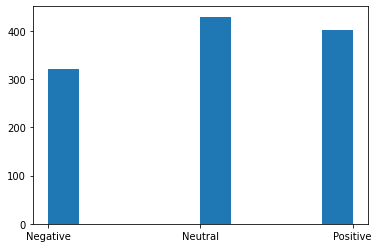

In [91]:
plt.hist(headLine.Sentiment)

In [58]:
output = []
for i in headLine.values:
    output.append(i[0]+' __label__'+i[1])

In [59]:
with open('./pandas.txt', 'w') as filehandle:
    for listitem in output:
        filehandle.write('%s\n' % listitem)

In [60]:
set([i.split(' __label__')[1] for i in output])

{'Negative', 'Neutral', 'Positive'}

## Fasttext

In [92]:
model = fasttext.train_supervised('./pandas.txt', dim=250)

Read 0M words
Number of words:  2523
Number of labels: 3
Progress: 100.0% words/sec/thread:  195094 lr:  0.000000 avg.loss:  1.117149 ETA:   0h 0m 0s


In [93]:
train_features = np.array([model.get_sentence_vector(i[0]) for i in headLine.values])
# test_features = np.array([model.get_sentence_vector(i[0]) for i in headLine_test1.values])
# val_features = np.array([model.get_sentence_vector(i[0]) for i in headLine_val1.values])

In [94]:
train_labels = headLine['Sentiment'].values
# val_labels = headLine_val1['Sentiment'].values

In [95]:
train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)

# Model Training

In [96]:
from sklearn.linear_model import LogisticRegression

In [97]:
from sklearn import svm

In [98]:
clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='l2')

In [99]:
clf.fit(train_features, train_labels)

LogisticRegression(random_state=0)

In [100]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(clf.score(test_features, test_labels))+'%')

From train set Accuracy= 0.4671916010498688%


In [101]:
clf = svm.SVC(degree=5)
clf.fit(train_features, train_labels)

SVC(degree=5)

In [102]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [103]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.5906207827260459%


In [104]:
clf = make_pipeline(StandardScaler(),svm.SVC(random_state=0, degree=10, tol=1e-5, C=2.))
clf.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=2.0, degree=10, random_state=0, tol=1e-05))])

In [105]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [106]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.6352226720647772%


In [107]:
clf = RandomForestClassifier(max_depth=50, random_state=0, criterion='entropy')
clf.fit(train_features, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=50, random_state=0)

In [108]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [109]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.6036437246963564%


In [110]:
from sklearn.neighbors import KNeighborsClassifier

In [111]:
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=20)

In [112]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [113]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.5406207827260459%


In [114]:
from sklearn.ensemble import GradientBoostingClassifier

In [115]:
clf = GradientBoostingClassifier(n_estimators=75, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(train_features, train_labels)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=75,
                           random_state=0)

In [116]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [117]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.5248313090418354%


## Microblogs

In [118]:
mb_train = pd.read_json("../input/nlp-s6-proj-data/Microblog_Trainingdata.json")
mb_val = pd.read_json("../input/nlp-s6-proj-data/Microblog_Trialdata.json")
mb_test = pd.read_json("../input/nlp-s6-proj-data/Microblogs_Testdata.json")

In [119]:
mb_train.head()

,source,cashtag,sentiment score,id,spans
0,twitter,$FB,0.366,719659409228451840,[watching for bounce tomorrow]
1,twitter,$LUV,0.638,719904304207962112,[record number of passengers served in 2015]
2,stocktwits,$NFLX,-0.494,5329774,[out $NFLX -.35]
3,twitter,$DIA,0.460,719891468173844480,"[Looking for a strong bounce, Lunchtime rally ..."
4,stocktwits,$PLUG,0.403,20091246,[Very intrigued with the technology and growth...


In [120]:
mb_train.values[0]

array(['twitter', '$FB', 0.366, 719659409228451840,
       list(['watching for bounce tomorrow'])], dtype=object)

In [121]:
mb_train.head()

,source,cashtag,sentiment score,id,spans
0,twitter,$FB,0.366,719659409228451840,[watching for bounce tomorrow]
1,twitter,$LUV,0.638,719904304207962112,[record number of passengers served in 2015]
2,stocktwits,$NFLX,-0.494,5329774,[out $NFLX -.35]
3,twitter,$DIA,0.460,719891468173844480,"[Looking for a strong bounce, Lunchtime rally ..."
4,stocktwits,$PLUG,0.403,20091246,[Very intrigued with the technology and growth...


In [122]:
pos_neg_neu_train = {-1:[], 0:[], 1:[]}

for i in mb_train.values:
    if(i[2]>-1 and i[2]<=-0.25):
        if(len(i[4])==1):
            pos_neg_neu_train[-1].append([i[4][0], i[2]])
        elif(len(i[4])>1):
            for k in i[4]:
                pos_neg_neu_train[-1].append([i[4][0], i[2]])
    if(i[2]>-0.25 and i[2]<=0.25):
        if(len(i[4])==1):
            pos_neg_neu_train[0].append([i[4][0], i[2]])
        elif(len(i[4])>1):
            for k in i[4]:
                pos_neg_neu_train[0].append([i[4][0], i[2]])
    if(i[2]>0.25 and i[2]<=1):
        if(len(i[4])==1):
            pos_neg_neu_train[1].append([i[4][0], i[2]])
        elif(len(i[4])>1):
            for k in i[4]:
                pos_neg_neu_train[1].append([i[4][0], i[2]])

In [123]:
pos_neg_neu_train

{-1: [['out $NFLX -.35', -0.494],
  ['overbought', -0.296],
  ['absolute garbage still up', -0.546],
  ['absolute garbage still up', -0.546],
  ['absolute garbage still up', -0.546],
  ['Biggest Market Losers', -0.438],
  ['$GOOG $GOOGL would suck', -0.398],
  ["who won't pay anymore", -0.349],
  ["who won't pay anymore", -0.349],
  ['now seems like its helping the downtrend', -0.372],
  ['big dumping', -0.699],
  ['big dumping', -0.699],
  ['Stochastic Overbought', -0.385],
  ['Insiders Are Selling', -0.351],
  ['What goes up...', -0.514],
  ['if $249.84 breaks we see $245 then $240', -0.519],
  ['Put the chum out there at key support then next level down', -0.32],
  ['Put the chum out there at key support then next level down', -0.32],
  ['Alibaba IPO hoopla canâ€™t hide risk of Chinese stocks', -0.39],
  ['$MDXG', -0.402],
  ['$MDXG', -0.402],
  ['Biggest Market Losers', -0.438],
  ['hip sinking?', -0.411],
  ['placed an order to sell 5 shares', -0.379],
  ['Short Setups Looking Nic

In [124]:
print('Negative headlines => ', str(len(pos_neg_neu_train[-1])),'\nNeutral headlines => ', str(len(pos_neg_neu_train[0])),'\nPositive headlines => ', str(len(pos_neg_neu_train[1])))

Negative headlines =>  562 
Neutral headlines =>  426 
Positive headlines =>  1090


In [125]:
pos_neg_neu_val = {-1:[], 0:[], 1:[]}

for i in mb_val.values:
    if(i[3]>-1 and i[3]<=-0.25):
#         pos_neg_neu_val[-1].append([i[1], i[3]])
        if(len(i[1])==1):
            pos_neg_neu_val[-1].append([i[1][0], i[3]])
        elif(len(i[1])>1):
            for k in i[1]:
                pos_neg_neu_val[-1].append([i[1][0], i[3]])
    if(i[3]>-0.25 and i[3]<=0.25):
#         pos_neg_neu_val[0].append([i[1], i[3]])
        if(len(i[1])==1):
            pos_neg_neu_val[0].append([i[1][0], i[3]])
        elif(len(i[1])>1):
            for k in i[1]:
                pos_neg_neu_val[0].append([i[1][0], i[3]])
    if(i[3]>0.25 and i[3]<=1):
#         pos_neg_neu_val[1].append([i[1], i[3]])
        if(len(i[1])==1):
            pos_neg_neu_val[1].append([i[1][0], i[3]])
        elif(len(i[1])>1):
            for k in i[1]:
                pos_neg_neu_val[1].append([i[1][0], i[3]])

In [126]:
pos_neg_neu_val

{-1: [['Putting on a little $F short', -0.454],
  ['short some', -0.464],
  ['its time to sell banks', -0.763],
  ['is a short below 740', -0.48],
  ['is a short below 740', -0.48]],
 0: [],
 1: [['buying opportunity', 0.445],
  ['Scaling Up on Long Position', 0.661],
  ['Entering long', 0.627],
  ['picked some up', 0.653],
  ['time to accumulate for a long position', 0.668],
  ['time to accumulate for a long position', 0.668],
  ['Buying $SBUX on dip', 0.483]]}

In [127]:
print('Negative headlines => ', str(len(pos_neg_neu_val[-1])),'\nNeutral headlines => ', str(len(pos_neg_neu_val[0])),'\nPositive headlines => ', str(len(pos_neg_neu_val[1])))

Negative headlines =>  5 
Neutral headlines =>  0 
Positive headlines =>  7


In [128]:
X_vals_tr = []
for i in pos_neg_neu_train:
    for j in pos_neg_neu_train[i]:
        X_vals_tr.append([j[0]])
        if(i == -1):
            X_vals_tr[-1].extend(['Negative'])
        elif(i == 0):
            X_vals_tr[-1].extend(['Neutral'])
        else:
            X_vals_tr[-1].extend(['Positive'])
X_vals_tr = np.array(X_vals_tr)

In [129]:
X_vals_tr

array([['out $NFLX -.35', 'Negative'],
       ['overbought', 'Negative'],
       ['absolute garbage still up', 'Negative'],
       ...,
       ['Buy stop above 80', 'Positive'],
       ['Airplane And Hospitality Industries Set Their Sights On #Cuba',
        'Positive'],
       ['nice bounce', 'Positive']], dtype='<U129')

In [130]:
microBlog_train = pd.DataFrame({'Title':X_vals_tr[:,0],'Sentiment':X_vals_tr[:,1]})

In [131]:
X_vals_vl = []
for i in pos_neg_neu_val:
    for j in pos_neg_neu_val[i]:
        X_vals_vl.append([j[0]])
        if(i == -1):
            X_vals_vl[-1].extend(['Negative'])
        elif(i == 0):
            X_vals_vl[-1].extend(['Neutral'])
        else:
            X_vals_vl[-1].extend(['Positive'])
X_vals_vl = np.array(X_vals_vl)

In [132]:
X_vals_vl[0]

array(['Putting on a little $F short', 'Negative'], dtype='<U38')

In [133]:
microBlog_val = pd.DataFrame({'Title':X_vals_vl[:,0],'Sentiment':X_vals_vl[:,1]})

In [134]:
microBlog_val.head()

,Title,Sentiment
0,Putting on a little $F short,Negative
1,short some,Negative
2,its time to sell banks,Negative
3,is a short below 740,Negative
4,is a short below 740,Negative


In [135]:
microBlog_train.head()

,Title,Sentiment
0,out $NFLX -.35,Negative
1,overbought,Negative
2,absolute garbage still up,Negative
3,absolute garbage still up,Negative
4,absolute garbage still up,Negative


In [136]:
microBlog = pd.concat([microBlog_train,microBlog_val])

In [137]:
microBlog.head()

,Title,Sentiment
0,out $NFLX -.35,Negative
1,overbought,Negative
2,absolute garbage still up,Negative
3,absolute garbage still up,Negative
4,absolute garbage still up,Negative


## Preprocessing

In [138]:
import nltk
from nltk.corpus import stopwords

In [139]:
def tokenize_data(dataset):
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    for i in range(dataset.shape[0]):
        dataset["Title"][i] = tokenizer.tokenize(dataset["Title"][i])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])
    return dataset

In [140]:
def remove_stop_words(dataset):
    stop_words = set(stopwords.words('english'))
    for i in range(dataset.shape[0]):
        dataset["Title"][i] = ([token.lower() for token in dataset["Title"][i] if token not in stop_words])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])
    return dataset

In [141]:
def normalize(dataset):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for i in range(dataset.shape[0]):
        dataset.Title[i] = " ".join([lemmatizer.lemmatize(token) for token in dataset.Title[i]]).strip()
#         dataset["Title"][i] = " ".join(dataset["Title"][i])

    return dataset

In [142]:
def remove_garbage(dataset):
    garbage = "~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    for i in range(dataset.shape[0]):
        dataset.Title[i] = " ".join([char for char in dataset.Title[i] if char not in garbage])
#         dataset["Title"][i] = " ".join(dataset["Title"][i])

    return dataset

In [144]:
microBlog['Title'][0]

0                  out $NFLX -.35
0    Putting on a little $F short
Name: Title, dtype: object

In [145]:
microBlog_train1 = tokenize_data(microBlog_train.copy())
microBlog_train1 = remove_stop_words(microBlog_train1)
microBlog_train1 = normalize(microBlog_train1)
microBlog_train1 = remove_garbage(microBlog_train1)

s2 = []
for ctr,k in enumerate(microBlog_train1['Title']):
    j = k.split('   ')
    s1 = []
    for i in j:
        s1.append(''.join([ij for ij in i if ij.isalnum()]))
    microBlog_train1['Title'][ctr] = ' '.join(s1)

In [146]:
microBlog_train1.head()

,Title,Sentiment
0,nflx 35,Negative
1,overbought,Negative
2,absolute garbage still,Negative
3,absolute garbage still,Negative
4,absolute garbage still,Negative


In [147]:
microBlog_val1 = tokenize_data(microBlog_val.copy())
microBlog_val1 = remove_stop_words(microBlog_val1)
microBlog_val1 = normalize(microBlog_val1)
microBlog_val1 = remove_garbage(microBlog_val1)

s2 = []
for ctr,k in enumerate(microBlog_val1['Title']):
    j = k.split('   ')
    s1 = []
    for i in j:
        s1.append(''.join([ij for ij in i if ij.isalnum()]))
    microBlog_val1['Title'][ctr] = ' '.join(s1)

In [148]:
microBlog_val1.head()

,Title,Sentiment
0,putting little f short,Negative
1,short,Negative
2,time sell bank,Negative
3,short 740,Negative
4,short 740,Negative


In [153]:
microBlog = pd.concat([microBlog_train1,microBlog_val1])

(array([ 567.,    0.,    0.,    0.,    0.,  426.,    0.,    0.,    0.,
        1097.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

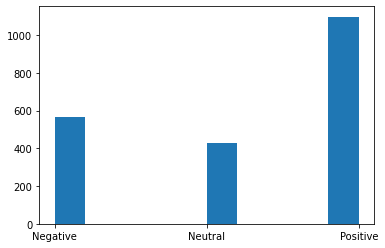

In [183]:
plt.hist(microBlog.Sentiment)

In [154]:
output = []
for i in microBlog.values:
    output.append(i[0]+' __label__'+i[1])

In [155]:
with open('./pandas_m.txt', 'w') as filehandle:
    for listitem in output:
        filehandle.write('%s\n' % listitem)

In [156]:
set([i.split(' __label__')[1] for i in output])

{'Negative', 'Neutral', 'Positive'}

## Fasttext

In [157]:
model = fasttext.train_supervised('./pandas_m.txt', dim=300)

Read 0M words
Number of words:  2064
Number of labels: 3
Progress: 100.0% words/sec/thread:  199552 lr:  0.000000 avg.loss:  0.969958 ETA:   0h 0m 0s


In [158]:
train_features = np.array([model.get_sentence_vector(i[0]) for i in microBlog.values])
# test_features = np.array([model.get_sentence_vector(i[0]) for i in headLine_test1.values])
# val_features = np.array([model.get_sentence_vector(i[0]) for i in headLine_val1.values])

In [159]:
train_labels = microBlog['Sentiment'].values

In [160]:
train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size=0.33, random_state=42)

# Model Training

In [161]:
from sklearn.linear_model import LogisticRegression

In [162]:
from sklearn import svm

In [163]:
clf = LogisticRegression(random_state=0, solver='lbfgs', penalty='l2')

In [164]:
clf.fit(train_features, train_labels)

LogisticRegression(random_state=0)

In [165]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(clf.score(test_features, test_labels))+'%')

From train set Accuracy= 0.8449275362318841%


In [166]:
clf = svm.SVC(degree=10)
clf.fit(train_features, train_labels)

SVC(degree=10)

In [167]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [168]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.8681159420289856%


In [169]:
clf = make_pipeline(StandardScaler(),svm.SVC(random_state=0, degree=10, tol=1e-5, C=2))
clf.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=2, degree=10, random_state=0, tol=1e-05))])

In [170]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [171]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.881159420289855%


In [172]:
clf = RandomForestClassifier(max_depth=100, random_state=0, criterion='entropy')
clf.fit(train_features, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=100, random_state=0)

In [173]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [174]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.8768115942028984%


In [175]:
from sklearn.neighbors import KNeighborsClassifier

In [176]:
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=20)

In [177]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [178]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.8492753623188406%


In [179]:
from sklearn.ensemble import GradientBoostingClassifier

In [180]:
clf = GradientBoostingClassifier(n_estimators=75, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(train_features, train_labels)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=75,
                           random_state=0)

In [181]:
scores = cross_val_score(clf, test_features, test_labels, cv=10)

In [182]:
# print('Validation Accuracy= '+str(clf.score(val_features, val_labels))+'%')
# for train data:        
print('From train set Accuracy= '+str(np.mean(scores))+'%')

From train set Accuracy= 0.8594202898550725%
